# **Montando o Drive**

In [1]:
# Coloca os arquivos do google drive disponíveis para serem usados pelo colab

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


# **Carregando o Arquivo das Bounding Boxes a ser Usado**

In [2]:
import torch

bboxes_xyxy = torch.load('/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/bounding_boxes_x1y1x2y2.pt', map_location=torch.device('cpu'))

In [ ]:
print(bboxes_xyxy)

[tensor([[2.5127e+02, 4.2401e-01, 3.1090e+02, 3.2243e+02],
        [3.4813e+02, 1.5105e+01, 4.0478e+02, 2.9856e+02],
        [1.6411e+02, 8.8678e-01, 2.1979e+02, 3.2280e+02],
        [3.5220e+02, 3.5758e+02, 4.0492e+02, 4.1600e+02],
        [6.8917e+01, 4.9374e-01, 1.2227e+02, 3.0069e+02],
        [2.5890e+02, 3.5693e+02, 3.0742e+02, 4.1600e+02],
        [6.8250e+01, 3.5765e+02, 1.2528e+02, 4.1600e+02],
        [2.7993e-01, 6.7502e+01, 3.2990e+01, 4.1325e+02],
        [1.6688e+02, 3.5290e+02, 2.1843e+02, 4.1598e+02],
        [0.0000e+00, 3.0746e-03, 3.4484e+01, 4.9461e+01]]), tensor([[2.7050e-02, 2.6591e+02, 4.1846e+01, 4.1600e+02],
        [2.6921e+02, 5.3375e-02, 3.1651e+02, 1.2222e+02],
        [7.6675e-02, 1.6743e-02, 5.4559e+01, 6.0878e+01],
        [1.7913e+02, 3.1190e-01, 2.2789e+02, 2.2705e+02],
        [2.7106e+02, 1.8175e+02, 3.1726e+02, 3.9249e+02],
        [8.3886e+01, 2.7101e+02, 1.2975e+02, 4.1600e+02],
        [3.6508e+02, 0.0000e+00, 4.0883e+02, 4.8067e+01],
        [3.

# **Cálculo das Falhas Entre as Bounding Box e o Limite da Imagem**

In [3]:
import os
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import re

def draw_line_with_length(draw, start, end, fill=(0, 0, 255), width=3, font=None):
    draw.line([start, end], fill=fill, width=width)
    line_length = int(((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2) ** 0.5)
    text_position = (end[0] + 5, (start[1] + end[1]) / 2 - 10)
    draw.text(text_position, f"{line_length}px", font=font, fill=fill)

def find_columns(boxes):
    columns = []
    for box in boxes:
        box_added = False
        for column in columns:
            if is_vertically_aligned(box, column[0]):
                column.append(box)
                box_added = True
                break
        if not box_added:
            columns.append([box])
    return columns

def is_vertically_aligned(box1, box2):
    x1_1, _, x2_1, _ = box1
    x1_2, _, x2_2, _ = box2
    return x1_1 <= x2_2 and x1_2 <= x2_1

font_path = "/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/arial.ttf"
font_size = 18
font = ImageFont.truetype(font_path, font_size) if font_path else None

folder_path = "/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/imagens_areas_calculadas"
image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpg')]

def extract_number(s):
    return int(re.search(r'(\d+)_area', s).group(1))

image_paths = sorted(image_paths, key=extract_number)

output_folder = '/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/imagens_falhas_total'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
total_distances = []

for i, (tensor, image_path) in enumerate(zip(bboxes_xyxy, image_paths)):
    image = cv2.imread(image_path)
    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)

    boxes = tensor.numpy()
    columns = find_columns(boxes)

    total_distance = 0

    for column in columns:
        # Sort boxes in the column by their y1 (top) coordinate
        column = sorted(column, key=lambda box: box[1])

        top_box = column[0]
        bottom_box = column[-1]

        # Draw a line from the toppest box to the top edge of the image
        avg_x_top = (top_box[0] + top_box[2]) / 2
        line_start_top = (avg_x_top, 0)
        line_end_top = (avg_x_top, top_box[1])
        draw_line_with_length(draw, line_start_top, line_end_top, fill=(0, 0, 255), width=3, font=font)
        total_distance += int(((line_end_top[0] - line_start_top[0]) ** 2 + (line_end_top[1] - line_start_top[1]) ** 2) ** 0.5)

        # Draw a line from the lowest box to the bottom edge of the image
        avg_x_bottom = (bottom_box[0] + bottom_box[2]) / 2
        line_start_bottom = (avg_x_bottom, bottom_box[3])
        line_end_bottom = (avg_x_bottom, image.shape[0])
        draw_line_with_length(draw, line_start_bottom, line_end_bottom, fill=(0, 0, 255), width=3, font=font)
        total_distance += int(((line_end_bottom[0] - line_start_bottom[0]) ** 2 + (line_end_bottom[1] - line_start_bottom[1]) ** 2) ** 0.5)

        # Draw lines between boxes in the same column
        for j in range(len(column) - 1):
            box1 = column[j]
            box2 = column[j + 1]
            avg_x = (box1[0] + box1[2] + box2[0] + box2[2]) / 4
            line_start = (avg_x, box1[3])
            line_end = (avg_x, box2[1])
            draw_line_with_length(draw, line_start, line_end, fill=(0, 0, 255), width=3, font=font)
            total_distance += int(((line_end[0] - line_start[0]) ** 2 + (line_end[1] - line_start[1]) ** 2) ** 0.5)

    # Add total distance to the list
    total_distances.append(total_distance)

    # Write the total distance on the image
    draw.text((5, 25), f"Falha: {total_distance}px", font=ImageFont.truetype("/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/arial.ttf", 18), fill=(255, 255, 255))

    image = np.array(pil_image)
    output_image_path = os.path.join(output_folder, f"image_{i}_falhas.jpg")
    cv2.imwrite(output_image_path, image)

    print(total_distances)



[214]
[214, 862]
[214, 862, 1057]
[214, 862, 1057, 754]
[214, 862, 1057, 754, 548]
[214, 862, 1057, 754, 548, 273]
[214, 862, 1057, 754, 548, 273, 494]
[214, 862, 1057, 754, 548, 273, 494, 286]
[214, 862, 1057, 754, 548, 273, 494, 286, 278]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119, 299]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119, 299, 239]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119, 299, 239, 314]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119, 299, 239, 314, 482]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119, 299, 239, 314, 482, 345]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119, 299, 239, 314, 482, 345, 460]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119, 299, 239, 314, 482, 345, 460, 1086]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119, 299, 239, 314, 482, 345, 460, 1086, 580]
[214, 862, 1057, 754, 548, 273, 494, 286, 278, 1119, 299, 239, 314, 482, 345, 460, 1086, 580, 271]
[

# **Cálculo das Falhas Entre as Bounding Box**

In [ ]:
import os
import cv2
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import re

def draw_line_with_length(draw, start, end, fill=(0, 0, 255), width=3, font=None):
    draw.line([start, end], fill=fill, width=width)
    line_length = int(((end[0] - start[0]) ** 2 + (end[1] - start[1]) ** 2) ** 0.5)
    text_position = (end[0] + 5, (start[1] + end[1]) / 2 - 10)  # Adjust the position of the text (x, y)
    draw.text(text_position, f"{line_length}px", font=font, fill=fill)

font_path = "/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/arial.ttf"  # Replace with the path to your font file
font_size = 18  # Adjust the font size
font = ImageFont.truetype(font_path, font_size) if font_path else None

folder_path = "/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/imagens_areas_calculadas"

image_paths = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith('.jpg')]

def extract_number(s):
    return int(re.search(r'(\d+)_area', s).group(1))

image_paths = sorted(image_paths, key=extract_number)

output_folder = '/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/imagens_falhas_total'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

def is_vertically_aligned(box1, box2):
    x1_1, _, x2_1, _ = box1
    x1_2, _, x2_2, _ = box2
    return x1_1 <= x2_2 and x1_2 <= x2_1

for i, (tensor, image_path) in enumerate(zip(bboxes_xyxy, image_paths)):
    image = cv2.imread(image_path)
    pil_image = Image.fromarray(image)
    draw = ImageDraw.Draw(pil_image)

    boxes = tensor.numpy()
    lines_drawn = 0

    for j in range(len(boxes)):
        min_distance = float('inf')
        closest_box_index = None
        for k in range(len(boxes)):
            if j != k and is_vertically_aligned(boxes[j], boxes[k]) and boxes[j][3] < boxes[k][1]:
                distance = abs(boxes[j][3] - boxes[k][1])
                if distance < min_distance:
                    min_distance = distance
                    closest_box_index = k

        if closest_box_index is not None:
            highest_box = boxes[j] if boxes[j][1] < boxes[closest_box_index][1] else boxes[closest_box_index]
            lowest_box = boxes[j] if boxes[j][1] > boxes[closest_box_index][1] else boxes[closest_box_index]
            avg_x = ((highest_box[0] + highest_box[2]) / 2 + (lowest_box[0] + lowest_box[2]) / 2) / 2
            line_start = (avg_x, highest_box[3])
            line_end = (avg_x, lowest_box[1])
            draw_line_with_length(draw, line_start, line_end, fill=(0, 0, 255), width=3, font=font)
            lines_drawn += 1

    # Write the number of lines drawn on the image
    draw.text((5, 25), f"Falhas: {lines_drawn}", font=ImageFont.truetype("/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/arial.ttf", 18), fill=(255, 255, 255))

    image = np.array(pil_image)
    output_image_path = os.path.join(output_folder, f"image_{i}_falhas.jpg")
    cv2.imwrite(output_image_path, image)


# **Plotando Gráfico Área Cultivada x Falha**

Text(0.5, 0, 'Total do tamanho das falhas (pixels)')

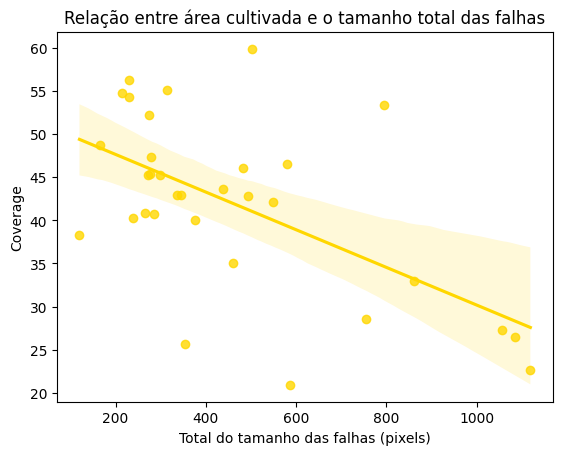

In [10]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

coverage = pd.read_csv('/content/drive/MyDrive/TG/arquiteturas/Ultralytics/YOLOv8/calculos/coverage_values.csv')

coverage.head()

sns.regplot(y = coverage['Coverage'], x = total_distances, color = '#FFD700')
plt.title('Relação entre área cultivada e o tamanho total das falhas')
plt.xlabel('Total do tamanho das falhas (pixels)')

Coeficiente de Correlação de Pearson: -0.5793220797270219


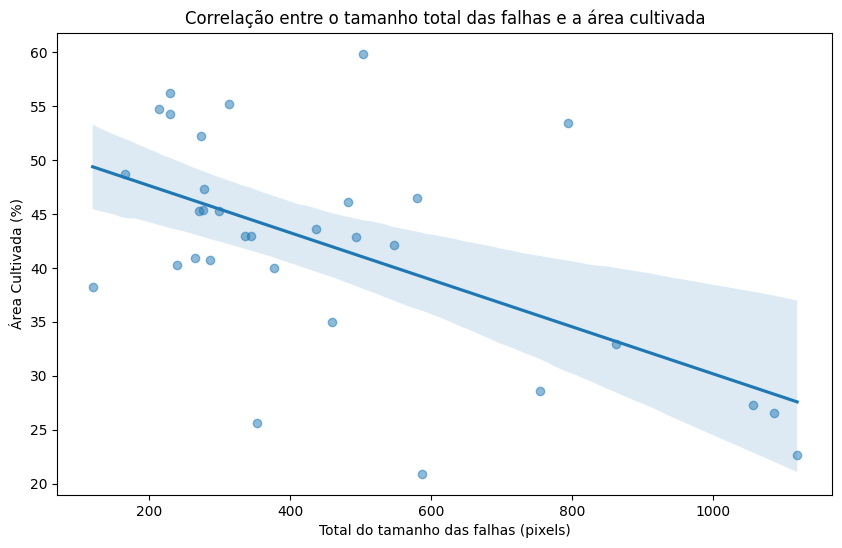

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Calculando a correlação
corr, _ = pearsonr(total_distances, coverage['Coverage'])
print('Coeficiente de Correlação de Pearson:', corr)

# Criando o gráfico de dispersão
plt.figure(figsize=(10, 6))
sns.regplot(y = coverage['Coverage'], x = total_distances, scatter_kws={'alpha':0.5})
plt.title('Correlação entre o tamanho total das falhas e a área cultivada')
plt.xlabel('Total do tamanho das falhas (pixels)')
plt.ylabel('Área Cultivada (%)')
plt.show()


In [ ]:
coverage

,Image,Coverage
0,image_0_area.jpg,54.743778
1,image_1_area.jpg,32.990997
2,image_2_area.jpg,27.308529
3,image_3_area.jpg,28.581228
4,image_4_area.jpg,42.124466
5,image_5_area.jpg,52.224815
6,image_6_area.jpg,42.866680
7,image_7_area.jpg,40.736614
8,image_8_area.jpg,47.336964
9,image_9_area.jpg,22.642605


In [16]:
import pandas as pd


average_coverage = coverage['Coverage'].mean()
print(f"A média da área cultivada é: {average_coverage}%")

total_faults_distance = sum(total_distances)
print(f"A somatória total das falhas é: {total_faults_distance}px")


A média da área cultivada é: 42.019897162914276%
A somatória total das falhas é: 14634px
